In [2]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [12]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [4]:
function revisedMat(
        A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}
        ) where {T <: Real}
    Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
    Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)
    return ((Ã₁⁻, Ã₁⁺), (Ã₂⁻, Ã₂⁺))
end

revisedMat (generic function with 1 method)

In [5]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [6]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [7]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [8]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [9]:
methodDescriptions = [
    "与えられた PCM を結合して整合化",
    "整合化しながら重要度の上・下近似を求めて PCM にする",
    "DM ごとに求めた重要度の上・下近似を整合化しながら結合して PCM にする",
    "DM ごとに求めた重要度の上・下近似から二重区間 PCM を作って結合して整合化する"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
    display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

    m = 2 # DM の数

    revisedMatrices = revisedMat(A₁, A₂)
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    
    for k = 1:length(resultMatrices)
        h = []
        for l = 1:m
            Âₖ⁻, Âₖ⁺ = resultMatrices[k]
            Ãₗ⁻, Ãₗ⁺ = revisedMatrices[l]

            title⁻ = L"\frac{\left| \tilde{A}_{%$(l)ij}^- \cap \hat{A}_{%$(k)ij}^- \right|}{\left| \tilde{A}_{%$(l)ij}^- \cup \hat{A}_{%$(k)ij}^- \right|}"
            title⁺ = L"\frac{\left| \tilde{A}_{%$(l)ij}^+ \cap \hat{A}_{%$(k)ij}^+ \right|}{\left| \tilde{A}_{%$(l)ij}^+ \cup \hat{A}_{%$(k)ij}^+ \right|}"

            heatmap⁻ = plotConincidenceIndices(Ãₗ⁻, Âₖ⁻, title⁻)
            heatmap⁺ = plotConincidenceIndices(Ãₗ⁺, Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
        end
        display(methodDescriptions[k])
        p = plot(h..., layout=(1, 4), size=(1000, 250), legend=false)

        display(p)
    end
end

plotAll (generic function with 1 method)

In [10]:
# 1 3 9
# 1/3 1 3
# 1/9 1/3 1

A₁ = [
    1..1 2.5..3.5 8..10
    (1/3.5)..(1/2.5) 1..1 2..4
    (1/10)..(1/8) (1/4)..(1/2) 1..1
]
A₂ = [
    1..1 2..4 7..12
    (1/4)..(1/2) 1..1 2..5
    (1/12)..(1/7) (1/5)..(1/2) 1..1
]

plotAll(A₁, A₂)

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.5, 3.5 \right] & \left[ 8.0, 10.0 \right] \\ \left[ 0.286, 0.4 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.0, 4.0 \right] \\ \left[ 0.1, 0.125 \right] & \left[ 0.25, 0.5 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.0, 4.0 \right] & \left[ 7.0, 12.0 \right] \\ \left[ 0.25, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.0, 5.0 \right] \\ \left[ 0.083, 0.143 \right] & \left[ 0.2, 0.5 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"与えられた PCM を結合して整合化"

LoadError: MethodError: no method matching getproperty(::Nothing, ::String)
[0mClosest candidates are:
[0m  getproperty([91m::PyCall.PyObject[39m, ::AbstractString) at /opt/julia/packages/PyCall/twYvK/src/PyCall.jl:317
[0m  getproperty([91m::PyPlot.LazyPyModule[39m, ::AbstractString) at /opt/julia/packages/PyPlot/NsAWt/src/plot3d.jl:16
[0m  getproperty([91m::PyPlot.Figure[39m, ::AbstractString) at /opt/julia/packages/PyPlot/NsAWt/src/PyPlot.jl:83
[0m  ...

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.05, 1.1 \right] & \left[ 1.1, 1.21 \right] \\ \left[ 0.909, 0.952 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.1, 1.22 \right] \\ \left[ 0.826, 0.909 \right] & \left[ 0.82, 0.909 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.3 \right] & \left[ 0.8, 1.23 \right] \\ \left[ 0.769, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.7, 1.3 \right] \\ \left[ 0.813, 1.25 \right] & \left[ 0.769, 1.429 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"与えられた PCM を結合して整合化"

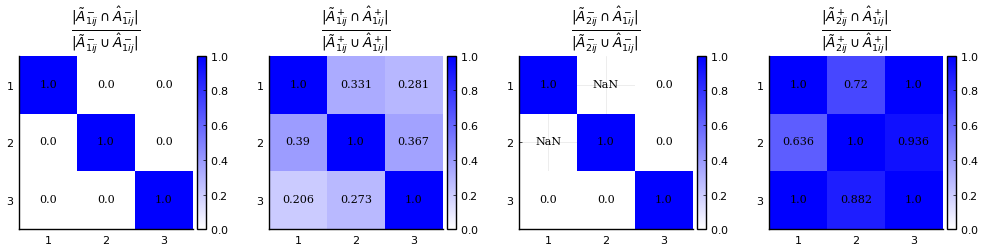

"整合化しながら重要度の上・下近似を求めて PCM にする"

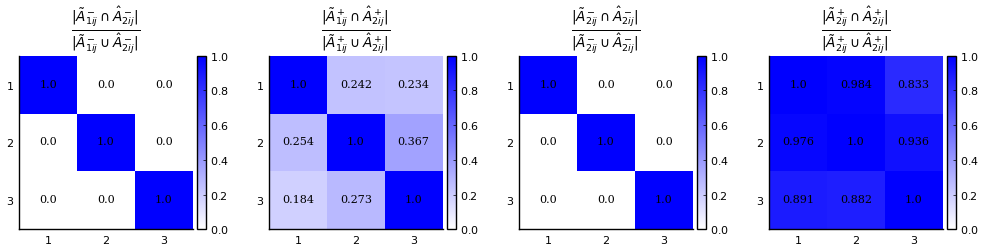

"DM ごとに求めた重要度の上・下近似を整合化しながら結合して PCM にする"

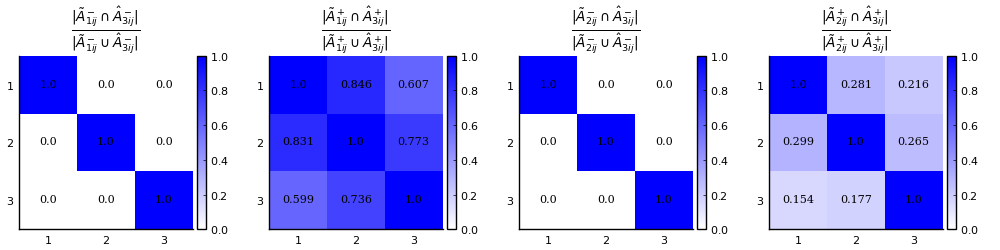

"DM ごとに求めた重要度の上・下近似から二重区間 PCM を作って結合して整合化する"

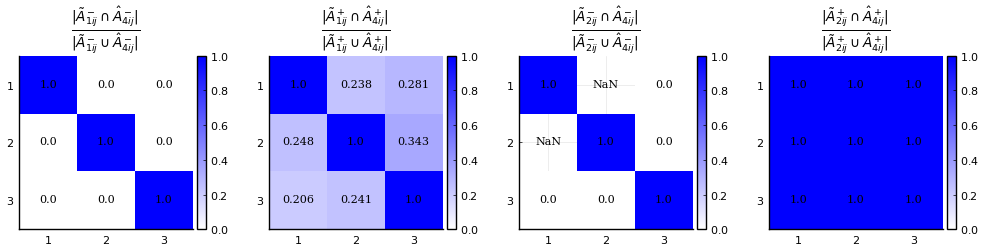

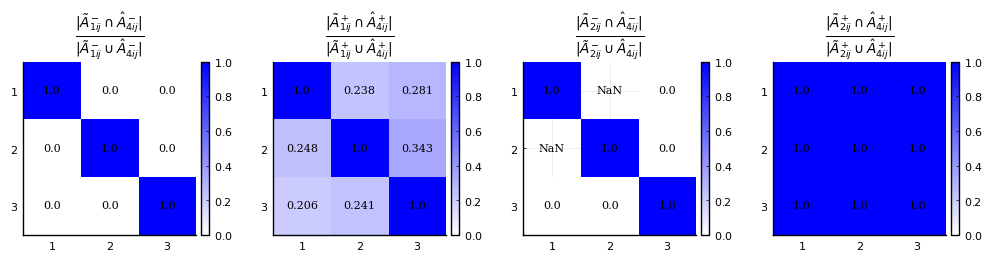

In [11]:
A₁ = [
    1..1 1.05..1.1 1.1..1.21
    (1/1.1)..(1/1.05) 1..1 1.1..1.22
    (1/1.21)..(1/1.1) (1/1.22)..(1/1.1) 1..1
]
A₂ = [
    1..1 1..1.3 0.8..1.23
    (1/1.3)..1 1..1 0.7..1.3
    (1/1.23)..(1/0.8) (1/1.3)..(1/0.7) 1..1
]

plotAll(A₁, A₂)